# CNN Models #

In [79]:
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Create Datasets for Modeling ##

In [69]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train, scale and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [118]:
# reshape labels
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]
y_model = y_model.T
y_test = y_test.T
print(y_model.shape)
print(y_test.shape)

(5232, 1)
(624, 1)


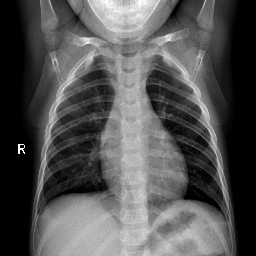

In [86]:
array_to_img(train_images[500])

In [87]:
y_model[500]

array([0.], dtype=float32)

### Split Training Data into Validation Set ###

In [90]:
X_train, X_val, y_train, y_val = train_test_split(train_images, y_model, test_size=0.20, random_state=765)

In [121]:
# check indices for normal-labeled images to verify we have the same set of images later on
normal_indices = [i for i, x in enumerate(y_train) if x == [0.]]
len(X_train), len(normal_indices)

(4185, 1087)

### Created Augmented Images ###

In [98]:
# augment images with given specification
idg_aug = ImageDataGenerator(rescale = 1./255,
                             rotation_range=45,
                             brightness_range = [0.8, 1.2])

# pull images from directory
aug_generator = idg_aug.flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# create aug data sets
aug_images, aug_labels = next(aug_generator)

Found 5232 images belonging to 2 classes.


In [120]:
# fix labels
y_aug_model = aug_labels.T[[1]]
y_aug_model = y_aug_model.T
print(y_aug_model.shape)

(5232, 1)


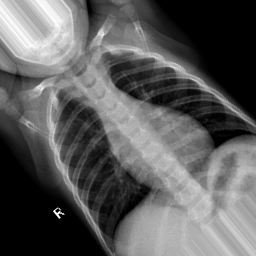

In [119]:
# check to see that augmented image 500 is the same as the orginal image 500
array_to_img(aug_images[500])

In [101]:
y_aug[500]

array([0.], dtype=float32)

### Split Augmented Data the Same Way as Training Data ###

This is so that we can use the same validation set for running models with regular images and augmented images.

In [108]:
X_aug, _, y_aug, _ = train_test_split(aug_images, y_aug_model, test_size=0.20, random_state=765)

In [122]:
# check indices for verification between normal and augmented sets
aug_indices = [i for i, x in enumerate(y_train) if x == [0.]]
len(X_aug), len(aug_indices)

(4185, 1087)

In [117]:
# check to see that the data was split the same way, meaning that the images in X_aug are the 
# same ones in X_train just transformed
normal_indices == aug_indices

True

## CNN Models ##

In [123]:
# function for visualizing loss, accuracy, and recall across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

### Model 1, on Normal Training Data ###

In [127]:
# build cnn model
cnn1 = Sequential()
cnn1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(32, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

In [128]:
# compile model
cnn1.compile(loss='binary_crossentropy',
              optimizer = "sgd",
              metrics=['accuracy', 'Recall'])

In [ ]:
# fit model on training set with normal images and validate on validation set
history_1 = cnn1.fit(X_train, y_train,
                     epochs=10,
                     batch_size=50,
                     validation_data=(X_val, y_val),
                     workers = -1)

Epoch 1/10
36/84 [===========>..................] - ETA: 4:25 - loss: 0.5777 - accuracy: 0.7289 - recall: 0.9730